## Project: Build a Traffic Sign Recognition Classifier

## Step 0: Load The Data
---

In [1]:
# Load pickled data
import pickle
import pandas as pd
import cv2
# TODO: Fill this in based on where you saved the training and testing data

training_file = 'traffic-signs-data/train.p'
validation_file= 'traffic-signs-data/valid.p'
testing_file = 'traffic-signs-data/test.p'

with open(training_file, mode='rb') as f:
    train = pickle.load(f)
with open(validation_file, mode='rb') as f:
    valid = pickle.load(f)
with open(testing_file, mode='rb') as f:
    test = pickle.load(f)
    
X_train, y_train = train['features'], train['labels']
X_valid, y_valid = valid['features'], valid['labels']
X_test, y_test = test['features'], test['labels']


with open('X_train_new.pk', mode='rb') as f:
    X_train_new = pd.read_pickle(f)
with open('X_test_new.pk', mode='rb') as f:
    X_test_new = pd.read_pickle(f)
with open('X_valid_new.pk', mode='rb') as f:
    X_valid_new = pd.read_pickle(f)
with open('y_train_new.pk', mode='rb') as f:
    y_train_new = pd.read_pickle(f)

---

## Step 1: Dataset Summary & Exploration

The pickled data is a dictionary with 4 key/value pairs:

- `'features'` is a 4D array containing raw pixel data of the traffic sign images, (num examples, width, height, channels).
- `'labels'` is a 1D array containing the label/class id of the traffic sign. The file `signnames.csv` contains id -> name mappings for each id.
- `'sizes'` is a list containing tuples, (width, height) representing the original width and height the image.
- `'coords'` is a list containing tuples, (x1, y1, x2, y2) representing coordinates of a bounding box around the sign in the image. **THESE COORDINATES ASSUME THE ORIGINAL IMAGE. THE PICKLED DATA CONTAINS RESIZED VERSIONS (32 by 32) OF THESE IMAGES**

### Provide a Basic Summary of the Data Set Using Python, Numpy and/or Pandas

In [2]:
import numpy as np
import pandas as pd

# TODO: Number of training examples
n_train = X_train.shape[0] #34799

# TODO: Number of validation examples
n_validation = X_valid.shape[0]

# TODO: Number of testing examples.
n_test = X_test.shape[0]

# TODO: What's the shape of an traffic sign image?
image_shape = X_train.shape[1:3]

# TODO: How many unique classes/labels there are in the dataset.
n_classes = len(np.unique(y_train))

print("Number of training examples =", n_train)
print("Number of testing examples =", n_test)
print("Image data shape =", image_shape)
print("Number of classes =", n_classes)

Number of training examples = 34799
Number of testing examples = 12630
Image data shape = (32, 32)
Number of classes = 43


### Include an exploratory visualization of the dataset

The [Matplotlib](http://matplotlib.org/) [examples](http://matplotlib.org/examples/index.html) and [gallery](http://matplotlib.org/gallery.html) pages are a great resource for doing visualizations in Python.

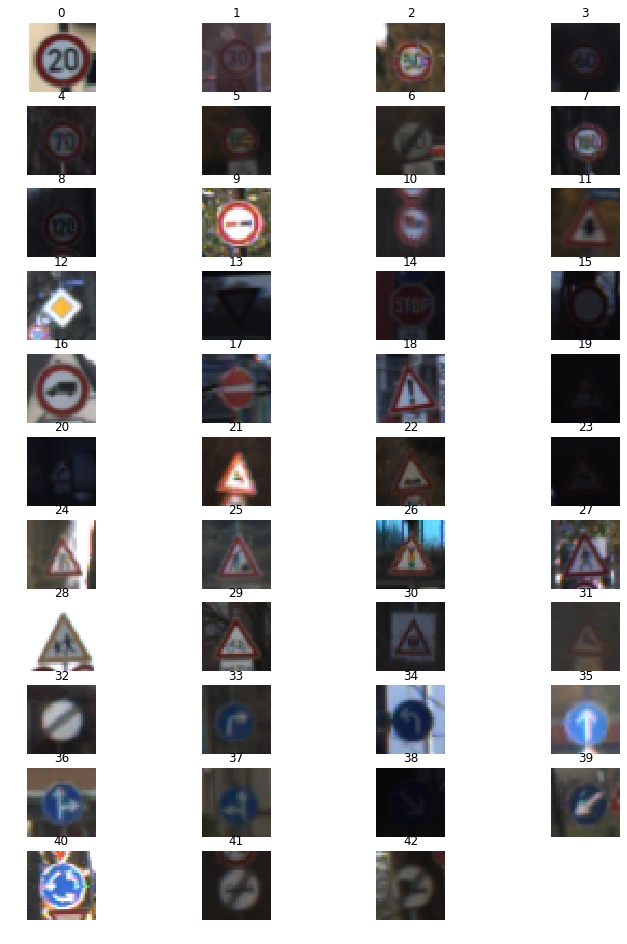

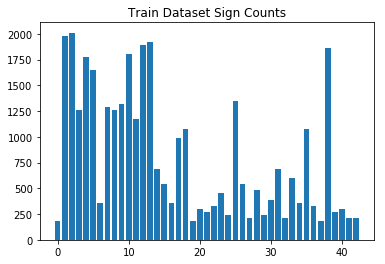

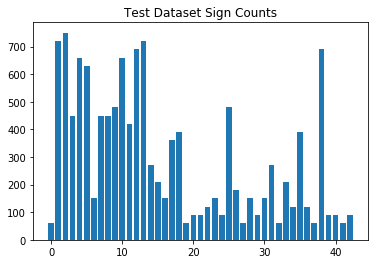

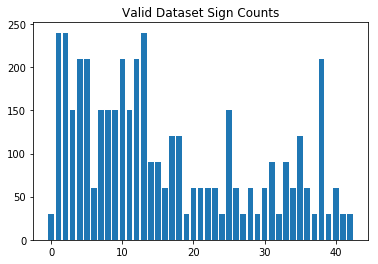

In [13]:
import random
import matplotlib.pyplot as plt
%matplotlib inline

num_of_samples=[]
plt.figure(figsize=(12, 16.5))
for i in range(0, n_classes):
    plt.subplot(11, 4, i+1)
    x_selected = X_train[y_train == i]
    plt.imshow(x_selected[0, :, :, :]) #draw the first image of each class
    plt.title(i)
    plt.axis('off')
plt.show()

# plt.figure(figsize=(12, 4))
# plt.bar(range(0, n_classes), num_of_samples)
# plt.title("Distribution of the train dataset")
# plt.xlabel("Class number")
# plt.ylabel("Number of images")
# plt.show()
#Plot number of images per class
unique_train, counts_train = np.unique(y_train, return_counts=True)
plt.bar(unique_train, counts_train)
plt.title("Train Dataset Sign Counts")
plt.show()


#Plot number of images per class

unique_test, counts_test = np.unique(y_test, return_counts=True)
plt.bar(unique_test, counts_test)
plt.title("Test Dataset Sign Counts")
plt.show()


#Plot number of images per class
unique_valid, counts_valid = np.unique(y_valid, return_counts=True)
plt.bar(unique_valid, counts_valid)
plt.title("Valid Dataset Sign Counts")
plt.show()


----

## Step 2: Design and Test a Model Architecture

Design and implement a deep learning model that learns to recognize traffic signs. Train and test your model on the [German Traffic Sign Dataset](http://benchmark.ini.rub.de/?section=gtsrb&subsection=dataset).

Here is an example of a [published baseline model on this problem](http://yann.lecun.com/exdb/publis/pdf/sermanet-ijcnn-11.pdf). It's not required to be familiar with the approach used in the paper but, it's good practice to try to read papers like these.

### Pre-process the Data Set (normalization, grayscale, etc.)

Minimally, the image data should be normalized so that the data has mean zero and equal variance. For image data, `(pixel - 128)/ 128` is a quick way to approximately normalize the data and can be used in this project. 

In [14]:
img_size=X_train.shape[1] #32


def sharpen_img(img):
    gb = cv2.GaussianBlur(img, (5,5), 20.0)
    return cv2.addWeighted(img, 2, gb, -1, 0)

def transform_img(img_in):
    img_in = img_in.copy()
    img_out= sharpen_img(img_in)
    img_out = cv2.cvtColor(img_out, cv2.COLOR_RGB2YUV)
    img_out[:,:,0] = cv2.equalizeHist(img_out[:,:,0])#YUV图像的Y轴进行直方均衡化
    img_out = cv2.cvtColor(img_out, cv2.COLOR_YUV2RGB)
    return img_out

def random_rotate_img(img):
    c_x,c_y = int(img.shape[0]/2), int(img.shape[1]/2)
    ang = 30.0*np.random.rand()-15
    Mat = cv2.getRotationMatrix2D((c_x, c_y), ang, 1.0)
    return cv2.warpAffine(img, Mat, img.shape[:2])

def random_scale_img(img):
    img2=img.copy()
    sc_y=0.4*np.random.rand()+1.0
    img2=cv2.resize(img, None, fx=1, fy=sc_y, interpolation = cv2.INTER_CUBIC)
    
    dy = int((img2.shape[1]-img.shape[0])/2)
    end = img.shape[1]-dy
    img2 = img2[dy:end,:,:]
    assert img2.shape[0] == 32
#     print(img2.shape,dy,end)
    return img2

#Compute linear image transformation ing*s+m
def lin_img(img,s=1.0,m=0.0):
    img2=cv2.multiply(img, np.array([s]))
    return cv2.add(img2, np.array([m]))

#Change image contrast; s>1 - increase
def contr_img(img, s=1.0):
    m=127.0*(1.0-s)
    return lin_img(img, s, m)


def augment_img(img):
    img = img.copy()
    img=contr_img(img, 1.8*np.random.rand()+0.2)
    img=random_rotate_img(img)
    img=random_scale_img(img)

    return transform_img(img)

(32, 32, 3)


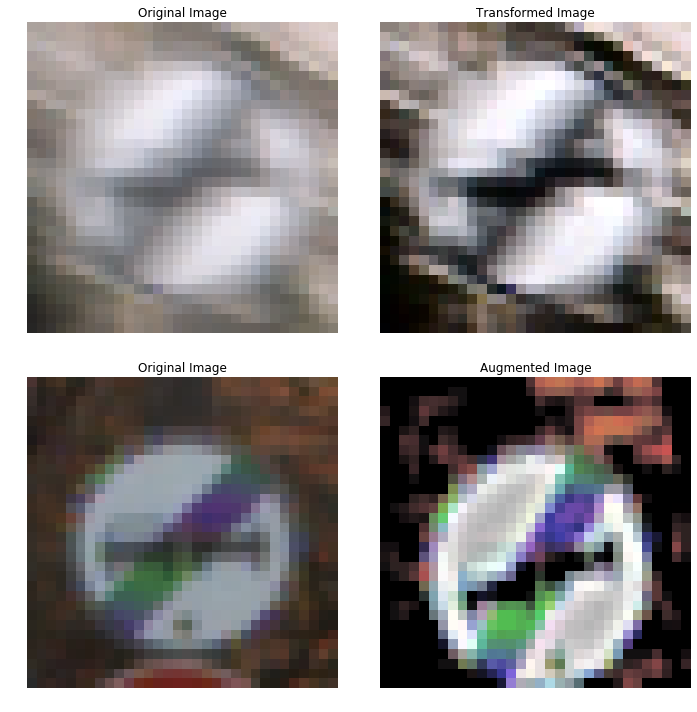

In [15]:
plt.figure(figsize=(10,10))
img = X_train[56]
plt.subplot(2,2,1)
plt.imshow(img)
plt.title('Original Image')
plt.axis('off')
plt.subplot(2,2,2)
plt.axis('off')
plt.imshow(transform_img(img))
plt.title('Transformed Image')

img = X_train[77]
plt.subplot(2,2,3)
plt.imshow(img)
plt.title('Original Image')
plt.axis('off')
plt.subplot(2,2,4)
plt.axis('off')
out = augment_img(img)
print(out.shape)
plt.imshow(out)
plt.title('Augmented Image')
plt.tight_layout()

In [16]:
# # transform all images and augment training datfa
# X_train_new = list()
# y_train_new = list()
# X_test_new = list()
# X_valid_new = list()
# for i in range(X_train.shape[0]):
#     img = X_train[i]
#     label = y_train[i]
    
#     imgout = transform_img(img)
#     X_train_new.append(imgout)
#     y_train_new.append(label)
#     for j in range(10): #每个图像对应添加十个fake图
#         imgout = augment_img(img)
#         X_train_new.append(imgout)
#         y_train_new.append(label)
    

# for i in range(X_valid.shape[0]):
#     img = X_valid[i]
#     img = transform_img(img)
#     X_valid_new.append(img)
    
# for i in range(X_test.shape[0]):
#     img = X_test[i]
#     img = transform_img(img)
#     X_test_new.append(img)

# X_test_new = np.array(X_test_new)
# X_train_new = np.array(X_train_new)
# X_valid_new = np.array(X_valid_new)
# y_train_new = np.array(y_train_new)


In [17]:
# with open('X_train_new.pk', mode='wb') as f:
#     pd.to_pickle(X_train_new, f)
# with open('X_test_new.pk', mode='wb') as f:
#     pd.to_pickle(X_test_new, f)
# with open('X_valid_new.pk', mode='wb') as f:
#     pd.to_pickle(X_valid_new, f)
# with open('y_train_new.pk', mode='wb') as f:
#     pd.to_pickle(y_train_new, f)

## Model Architecture
Implement the [LeNet-5](http://yann.lecun.com/exdb/lenet/) neural network architecture.
### Input
The LeNet architecture accepts a 32x32xC image as input, where C is the number of color channels. 
### Architecture
**Layer 1: Convolutional.** The output shape should be 28x28x6.

**Activation.** Your choice of activation function.

**Pooling.** The output shape should be 14x14x6.

**Layer 2: Convolutional.** The output shape should be 10x10x16.

**Activation.** Your choice of activation function.

**Pooling.** The output shape should be 5x5x16.

**Flatten.** Flatten the output shape of the final pooling layer such that it's 1D instead of 3D. The easiest way to do is by using `tf.contrib.layers.flatten`, which is already imported for you.

**Layer 3: Fully Connected.** This should have 120 outputs.

**Activation.** Your choice of activation function.

**Layer 4: Fully Connected.** This should have 84 outputs.

**Activation.** Your choice of activation function.

**Layer 5: Fully Connected (Logits).** This should have 10 outputs.

### Output
Return the result of the 2nd fully connected layer.

In [7]:
import tensorflow as tf
from tensorflow.contrib.layers import flatten
from sklearn.utils import shuffle

EPOCHS = 50
BATCH_SIZE = 256
rate = 0.0008
dropout = 0.3

def LeNet(x):    
    # Arguments used for tf.truncated_normal, randomly defines variables for the weights and biases for each layer
    mu = 0
    sigma = 0.1
    
    # SOLUTION: Layer 1: Convolutional. Input = 32x32x1. Output = 28x28x6.
    conv1_W = tf.Variable(tf.truncated_normal(shape=(5, 5, 3, 6), mean = mu, stddev = sigma)) 
    # [filter_height, filter_width, in_channels, out_channels]
    conv1_b = tf.Variable(tf.zeros(6))
    conv1   = tf.nn.conv2d(x, conv1_W, strides=[1, 1, 1, 1], padding='VALID') + conv1_b
    # (batch, height, width, depth)

    # SOLUTION: Activation.
    conv1 = tf.nn.relu(conv1)

    # SOLUTION: Pooling. Input = 28x28x6. Output = 14x14x6.
    conv1 = tf.nn.max_pool(conv1, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='VALID')

    # SOLUTION: Layer 2: Convolutional. Output = 10x10x16.
    conv2_W = tf.Variable(tf.truncated_normal(shape=(5, 5, 6, 16), mean = mu, stddev = sigma))
    conv2_b = tf.Variable(tf.zeros(16))
    conv2   = tf.nn.conv2d(conv1, conv2_W, strides=[1, 1, 1, 1], padding='VALID') + conv2_b
    
    # SOLUTION: Activation.
    conv2 = tf.nn.relu(conv2)

    # SOLUTION: Pooling. Input = 10x10x16. Output = 5x5x16.
    conv2 = tf.nn.max_pool(conv2, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='VALID')

    # SOLUTION: Flatten. Input = 5x5x16. Output = 400.
    fc0   = flatten(conv2)
    
    # SOLUTION: Layer 3: Fully Connected. Input = 400. Output = 120.
    fc1_W = tf.Variable(tf.truncated_normal(shape=(400, 120), mean = mu, stddev = sigma))
    fc1_b = tf.Variable(tf.zeros(120))
    fc1   = tf.matmul(fc0, fc1_W) + fc1_b
    
    # SOLUTION: Activation.
    fc1    = tf.nn.relu(fc1)
    dr1    = tf.nn.dropout(fc1, keep_prob) 
    # SOLUTION: Layer 4: Fully Connected. Input = 120. Output = 84.
    fc2_W  = tf.Variable(tf.truncated_normal(shape=(120, 84), mean = mu, stddev = sigma))
    fc2_b  = tf.Variable(tf.zeros(84))
    fc2    = tf.matmul(dr1, fc2_W) + fc2_b
    
    # SOLUTION: Activation.
    fc2    = tf.nn.relu(fc2)
    dr2    = tf.nn.dropout(fc2, keep_prob) 
    # SOLUTION: Layer 5: Fully Connected. Input = 84. Output = 43.
    fc3_W  = tf.Variable(tf.truncated_normal(shape=(84, 43), mean = mu, stddev = sigma))
    fc3_b  = tf.Variable(tf.zeros(43))
    logits = tf.matmul(dr2, fc3_W) + fc3_b
    
    return logits

x = tf.placeholder(tf.float32, (None, 32, 32, 3)) #[batch, in_height, in_width, in_channels]
y = tf.placeholder(tf.int32, (None))
keep_prob = tf.placeholder(tf.float32)
# learning_rate = tf.placeholder(tf.float32)
one_hot_y = tf.one_hot(y, 43) 
# `x` is a placeholder for a batch of input images.
# `y` is a placeholder for a batch of output labels.

logits = LeNet(x)
cross_entropy = tf.nn.softmax_cross_entropy_with_logits_v2(labels=one_hot_y, logits=logits)
loss_operation = tf.reduce_mean(cross_entropy)
optimizer = tf.train.AdamOptimizer(learning_rate=rate)
training_operation = optimizer.minimize(loss_operation)

correct_prediction = tf.equal(tf.argmax(logits, 1), tf.argmax(one_hot_y, 1))
accuracy_operation = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))
saver = tf.train.Saver()

def evaluate(X_data, y_data):
    num_examples = len(X_data)
    total_accuracy = 0
    sess = tf.get_default_session()
    for offset in range(0, num_examples, BATCH_SIZE):
        batch_x, batch_y = X_data[offset:offset+BATCH_SIZE], y_data[offset:offset+BATCH_SIZE]
        accuracy = sess.run(accuracy_operation, feed_dict={x: batch_x, y: batch_y, keep_prob: 1.0})
        total_accuracy += (accuracy * len(batch_x))
    return total_accuracy / num_examples

### Train, Validate and Test the Model

A validation set can be used to assess how well the model is performing. A low accuracy on the training and validation
sets imply underfitting. A high accuracy on the training set but low accuracy on the validation set implies overfitting.

In [8]:
with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    num_examples = len(X_train_new)
    
    print("Training...")
    print()
    for i in range(EPOCHS):
        X_train_new, y_train_new = shuffle(X_train_new, y_train_new)
        for offset in range(0, num_examples, BATCH_SIZE):
            end = offset + BATCH_SIZE
            batch_x, batch_y = X_train_new[offset:end], y_train_new[offset:end]
            sess.run(training_operation, feed_dict={x: batch_x, y: batch_y, keep_prob: 1-dropout})
            
        validation_accuracy = evaluate(X_valid_new, y_valid)
        if (i+1)%5== 1:
            print("EPOCH {} ...".format(i+1))
            print("Validation Accuracy = {:.3f}".format(validation_accuracy))
            print()
        
    saver.save(sess, './LeNet-5/lenet')
    print("Model saved")

Training...

EPOCH 1 ...
Validation Accuracy = 0.575

EPOCH 6 ...
Validation Accuracy = 0.876

EPOCH 11 ...
Validation Accuracy = 0.911

EPOCH 16 ...
Validation Accuracy = 0.929

EPOCH 21 ...
Validation Accuracy = 0.935

EPOCH 26 ...
Validation Accuracy = 0.936

EPOCH 31 ...
Validation Accuracy = 0.937

EPOCH 36 ...
Validation Accuracy = 0.938

EPOCH 41 ...
Validation Accuracy = 0.935

EPOCH 46 ...
Validation Accuracy = 0.938

Model saved


In [9]:
# TEST
with tf.Session() as sess:
    saver.restore(sess, tf.train.latest_checkpoint('./LeNet-5/'))

    test_accuracy = evaluate(X_test_new, y_test)
    print("Test Accuracy = {:.3f}".format(test_accuracy))

INFO:tensorflow:Restoring parameters from ./LeNet-5/lenet
Test Accuracy = 0.913


---

## Step 3: Test a Model on New Images

To give yourself more insight into how your model is working, download at least five pictures of German traffic signs from the web and use your model to predict the traffic sign type.

You may find `signnames.csv` useful as it contains mappings from the class id (integer) to the actual sign name.

### Load and Output the Images

In [ ]:
### Load the images and plot them here.
### Feel free to use as many code cells as needed.

### Predict the Sign Type for Each Image

In [ ]:
### Run the predictions here and use the model to output the prediction for each image.
### Make sure to pre-process the images with the same pre-processing pipeline used earlier.
### Feel free to use as many code cells as needed.

### Analyze Performance

For each of the new images, print out the model's softmax probabilities to show the **certainty** of the model's predictions (limit the output to the top 5 probabilities for each image). [`tf.nn.top_k`](https://www.tensorflow.org/versions/r0.12/api_docs/python/nn.html#top_k) could prove helpful here. 

The example below demonstrates how tf.nn.top_k can be used to find the top k predictions for each image.

`tf.nn.top_k` will return the values and indices (class ids) of the top k predictions. So if k=3, for each sign, it'll return the 3 largest probabilities (out of a possible 43) and the correspoding class ids.

Take this numpy array as an example. The values in the array represent predictions. The array contains softmax probabilities for five candidate images with six possible classes. `tf.nn.top_k` is used to choose the three classes with the highest probability:

```
# (5, 6) array
a = np.array([[ 0.24879643,  0.07032244,  0.12641572,  0.34763842,  0.07893497,
         0.12789202],
       [ 0.28086119,  0.27569815,  0.08594638,  0.0178669 ,  0.18063401,
         0.15899337],
       [ 0.26076848,  0.23664738,  0.08020603,  0.07001922,  0.1134371 ,
         0.23892179],
       [ 0.11943333,  0.29198961,  0.02605103,  0.26234032,  0.1351348 ,
         0.16505091],
       [ 0.09561176,  0.34396535,  0.0643941 ,  0.16240774,  0.24206137,
         0.09155967]])
```

Running it through `sess.run(tf.nn.top_k(tf.constant(a), k=3))` produces:

```
TopKV2(values=array([[ 0.34763842,  0.24879643,  0.12789202],
       [ 0.28086119,  0.27569815,  0.18063401],
       [ 0.26076848,  0.23892179,  0.23664738],
       [ 0.29198961,  0.26234032,  0.16505091],
       [ 0.34396535,  0.24206137,  0.16240774]]), indices=array([[3, 0, 5],
       [0, 1, 4],
       [0, 5, 1],
       [1, 3, 5],
       [1, 4, 3]], dtype=int32))
```

Looking just at the first row we get `[ 0.34763842,  0.24879643,  0.12789202]`, you can confirm these are the 3 largest probabilities in `a`. You'll also notice `[3, 0, 5]` are the corresponding indices.

In [ ]:
### Print out the top five softmax probabilities for the predictions on the German traffic sign images found on the web. 
### Feel free to use as many code cells as needed.

# Step 4 (Optional): Visualize the Neural Network's State with Test Images¶

In [10]:
### Visualize your network's feature maps here.
### Feel free to use as many code cells as needed.

# image_input: the test image being fed into the network to produce the feature maps
# tf_activation: should be a tf variable name used during your training procedure that represents the calculated state of a specific weight layer
# activation_min/max: can be used to view the activation contrast in more detail, by default matplot sets min and max to the actual min and max values of the output
# plt_num: used to plot out multiple different weight feature map sets on the same block, just extend the plt number for each new feature map entry

def outputFeatureMap(image_input, tf_activation, activation_min=-1, activation_max=-1 ,plt_num=1):
    # Here make sure to preprocess your image_input in a way your network expects
    # with size, normalization, ect if needed
    # image_input =
    # Note: x should be the same name as your network's tensorflow data placeholder variable
    # If you get an error tf_activation is not defined it may be having trouble accessing the variable from inside a function
    activation = tf_activation.eval(session=sess,feed_dict={x : image_input})
    featuremaps = activation.shape[3]
    plt.figure(plt_num, figsize=(15,15))
    for featuremap in range(featuremaps):
        plt.subplot(6,8, featuremap+1) # sets the number of feature maps to show on each row and column
        plt.title('FeatureMap ' + str(featuremap)) # displays the feature map number
        if activation_min != -1 & activation_max != -1:
            plt.imshow(activation[0,:,:, featuremap], interpolation="nearest", vmin =activation_min, vmax=activation_max, cmap="gray")
        elif activation_max != -1:
            plt.imshow(activation[0,:,:, featuremap], interpolation="nearest", vmax=activation_max, cmap="gray")
        elif activation_min !=-1:
            plt.imshow(activation[0,:,:, featuremap], interpolation="nearest", vmin=activation_min, cmap="gray")
        else:
            plt.imshow(activation[0,:,:, featuremap], interpolation="nearest", cmap="gray")

In [1]:
import numpy as np
import pandas as pd